(160, 360, 2)
(160, 180, 2)
0
Actual DoAs: [173]
MUSIC DoAs: [ 63  71  80  84  87  99 104]
1
Actual DoAs: [141]
MUSIC DoAs: [141]
2
Actual DoAs: [114]
MUSIC DoAs: [114]
3
Actual DoAs: [22]
MUSIC DoAs: [ 71  96 100 106 108]
4
Actual DoAs: [123]
MUSIC DoAs: [123]
5
Actual DoAs: [8]
MUSIC DoAs: [ 80  85  87  94 102 104]
6
Actual DoAs: [43]
MUSIC DoAs: []
7
Actual DoAs: [131]
MUSIC DoAs: [ 49 131]
8
Actual DoAs: [28]
MUSIC DoAs: [ 99 101 103 108 112]
9
Actual DoAs: [36]
MUSIC DoAs: []


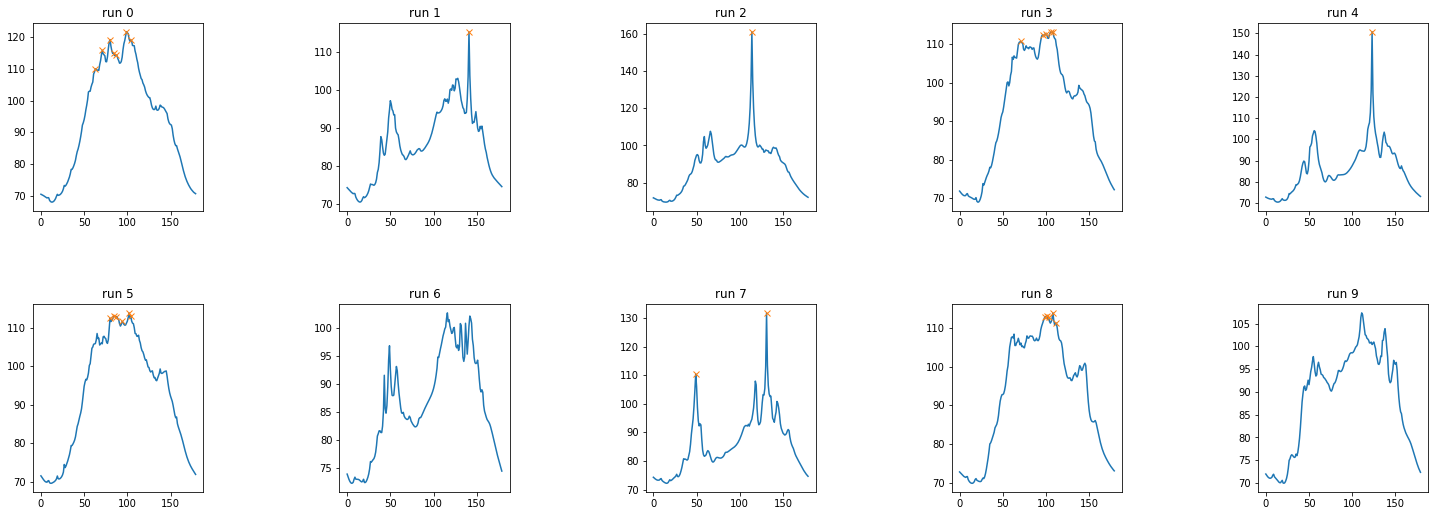

In [16]:
#Implementation found in https://github.com/dengjunquan/DoA-Estimation-MUSIC-ESPRIT/blob/master/DoAEstimation.py
# https://dengjunquan.github.io/posts/2018/08/DoAEstimation_Python/

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
import scipy.signal as ss
import operator
import math
import os
import datetime
import logging



#### LITTLE BUG if one of the thetas is in the extremes (0 or 179) the graph is good but not retrieved

# Functions
'''
'''
def music(CovMat,L,N,array,Angles, frequency):
    # CovMat is the signal covariance matrix, L is the number of sources, N is the number of antennas
    # array holds the positions of antenna elements 
    #(array and Angles ONLY USEFUL FOR response vector so should give response vector instead)
    # Angles are the grid of directions in the azimuth angular domain
    _,V = LA.eig(CovMat)
    #print(V)
    #print("JUSTE EN HAUT")
    Qn  = V[:,L:N]
    numAngles = Angles.size
    pspectrum = np.zeros(numAngles)
    for i in range(numAngles):
        av = array[:,Angles[i],frequency]
        pspectrum[i] = 1/LA.norm((Qn.conj().transpose()@av))
    
    psindB    = np.log10(10*pspectrum/pspectrum.min())
    #DoAsMUSIC,_= ss.find_peaks(psindB, height=3)
    return psindB


outpath = os.path.join('output',  '{:%Y%m%d_%H%M}'.format(datetime.datetime.now()))
if not os.path.exists(outpath):
    os.makedirs(outpath)

logfile = os.path.join(outpath, "log.txt")

logging.basicConfig(filename=logfile, format='%(asctime)s %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)


lamda = 1 # wavelength
kappa = np.pi/lamda # wave number
L = 1  # number of sources
snr = 20 # signal to noise ratio
n_samples = 128
discretization = 0


dev = 'kemar' # Change if using Kemar or lego
logger.info('Load transfer functions %s'%dev)

if dev == 'lego':
    discretization = 2
    H_theta_time_total = np.load('lego1_h_theta_time.npy')    

#Change Kemar discretization to be every 2 degrees

if dev == 'kemar':
    discretization = 2
    H_theta_time_total = np.load('kemar_h_theta_1deg_time.npy')   
    H_theta_time_total = H_theta_time_total[:,::discretization,:]


runs = 10

logger.info('Number of runs %s'%(runs))
logger.info('Noise in decibel %s'%(snr))
logger.info('Number of sources %s'%(L))

number_mics = H_theta_time_total.shape[2]
N = number_mics


H_theta_freq_total = []
for mic in range(number_mics):
    H_theta_freq_total.append(np.fft.rfft(np.transpose(H_theta_time_total[:,:,mic]), n_samples))

H_theta_freq_total = np.asarray(H_theta_freq_total)

numFrequencies = H_theta_freq_total.shape[2]

logger.info('Number of frequencies %s'%(numFrequencies))    

#Example Getting the first frquency of the 12th angle
#H_theta_freq_test = H_theta_freq_total[:,12,1]
    
Df = H_theta_freq_total.shape[1] #number of directions for a fine discretization
xPlot = 10 #runs/yplot
yPlot = 5 #runs/xplot
fig = plt.figure(figsize=(25,50))#give enough size to plot 50 subplots

for rns in range(runs):
    print(rns)

    # random source directions in degrees (actually it's the indexes for degrees times 2)
    Thetas = np.random.choice(range(Df), L, replace=False) 

    #Thetas[2] = 0 If i want to try extremes ones to debug

    Alphas = np.random.randn(L) + np.random.randn(L)*1j # random source powers

    Alphas = np.sqrt(1/2)*Alphas

    Angles = np.arange(Df, dtype=np.int64)*360./Df # list of angles in degrees
    Angles = (Angles/discretization).astype(int)

    numAngles = Angles.size

    psindTotal = np.zeros((Df, ))    
    
    #not taking the first frequency because neutral one
    for frequency in range (1, numFrequencies): 

        numrealization = 100
        H = np.zeros((N,numrealization)) + 1j*np.zeros((N,numrealization))
        for iter in range(numrealization):
            htmp = np.zeros(N)
            #Signal generation
            for i in range(L):
                pha = np.exp(1j*2*np.pi*np.random.rand(1))
                htmp = htmp + pha*Alphas[i]*H_theta_freq_total[:,Thetas[i],frequency]
            #Adding noise
            H[:,iter] = htmp + np.sqrt(0.5/snr)*(np.random.randn(N)+np.random.randn(N)*1j)
        CovMat = H@H.conj().transpose()

        # MUSIC algorithm
        psindB = music(CovMat,L,N,H_theta_freq_total,Angles, frequency)

        psindTotal = psindTotal + psindB

    DoAsMUSIC,_= ss.find_peaks(psindTotal, height=110)

    plt.subplot(xPlot, yPlot, rns+1)
    plt.plot(Angles,psindTotal)
    plt.plot(Angles[DoAsMUSIC],psindTotal[DoAsMUSIC],'x')
    plt.title('run %s'%(rns))

    print('Actual DoAs: %s'%(np.sort(Thetas)))
    print('MUSIC DoAs: %s'%(np.sort(Angles[DoAsMUSIC])))
    
    logger.info('Actual DoAs: %s'%(np.sort(Thetas)))
    logger.info('MUSIC DoAs: %s'%(np.sort(Angles[DoAsMUSIC])))

    musicContainedThetas = np.isin(DoAsMUSIC, Thetas)

    thetasContainedMusic = np.isin(Thetas, DoAsMUSIC)

    fullyContained = np.all(np.append(musicContainedThetas, thetasContainedMusic))
    logger.info('Run %s : '%(rns))

    if fullyContained:
        logger.info('Found every source')
    else:
        numberWrongSource = np.count_nonzero(musicContainedThetas==False)
        numberNotFoundSource = np.count_nonzero(thetasContainedMusic==False)
        if(numberNotFoundSource == 0):
            logger.info('Found every source but found %s more sources'%(numberWrongSource))
        elif(numberWrongSource == 0):
            logger.info('Found only good sources but didn\'t find %s source(s)' %(numberNotFoundSource))
        else:
            logger.info('Found %s wrong source(s) and didn\'t find %s source(s)' %(numberWrongSource, numberNotFoundSource))
        

    
    #print('Actual DoAs:',np.sort(Thetas),'\n')
    #print('MUSIC DoAs:',np.sort(Angles[DoAsMUSIC]),'\n')
plt.subplots_adjust(wspace=0.8, hspace=0.5)
plt.savefig(os.path.join(outpath, 'music.png'))
